# Behavior Analysis: Distance Traveled Stats + Movement Heatmaps

Press SHIFT + ENTER to run code

### USER INPUT!

In [3]:
## Define project
project_name = 'project_ACC_Study4_NociFormalinResponse'

# Select group and condition, see meta.py to see how you previously defined it for your project
selected_groups = ['Male','Female']
selected_conditions = ['Group6_1PerFormalin','Group7_5PerFormalin']

### Main Code: Create CSVs + Heatmaps w/ Distance Traveled

Average distance traveled for group 'Male' and condition 'Group6_1PerFormalin': 11804.49 cm
Standard deviation: 808.05 cm
Standard error of the mean (SEM): 361.37 cm
Cumulative distance traveled: 59022.47 cm
Average distance traveled for group 'Male' and condition 'Group7_5PerFormalin': 12187.43 cm
Standard deviation: 661.87 cm
Standard error of the mean (SEM): 296.00 cm
Cumulative distance traveled: 60937.14 cm
Average distance traveled for group 'Female' and condition 'Group6_1PerFormalin': 12820.63 cm
Standard deviation: 594.30 cm
Standard error of the mean (SEM): 265.78 cm
Cumulative distance traveled: 64103.14 cm
Average distance traveled for group 'Female' and condition 'Group7_5PerFormalin': 11621.84 cm
Standard deviation: 1464.45 cm
Standard error of the mean (SEM): 654.92 cm
Cumulative distance traveled: 58109.18 cm


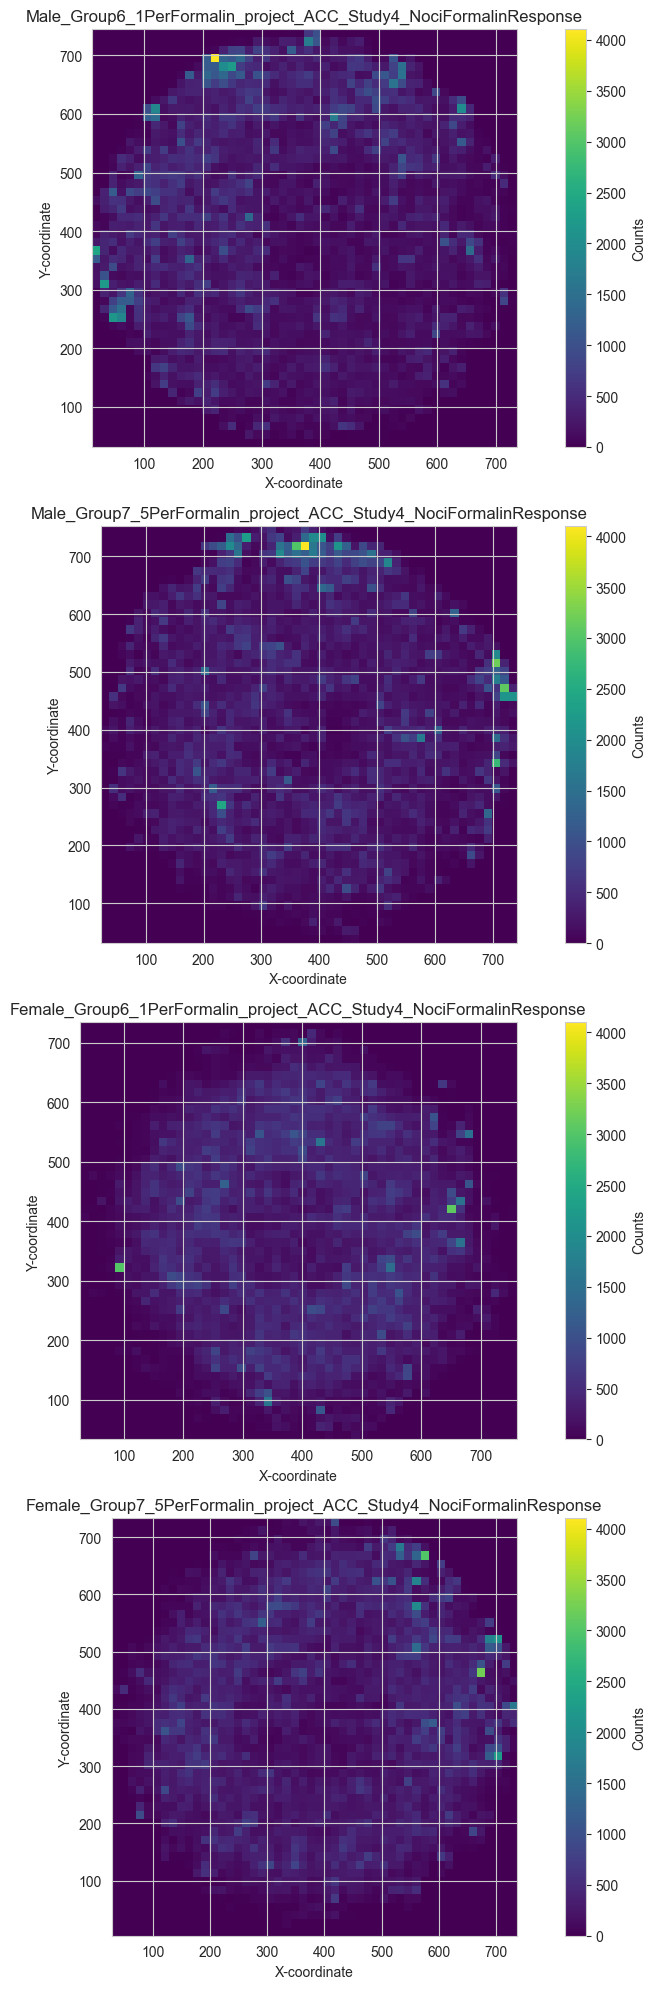

In [4]:
###### RUN DEPENDENCIES ######
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import csv
if not os.path.join(os.path.abspath(''), '../') in sys.path:
    sys.path.append(os.path.join(os.path.abspath(''), '../'))
from utils.classification import load_behaviors, load_data
from utils.meta import *
import matplotlib
import warnings
import seaborn as sns
from matplotlib.patches import Circle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

###### Load Pose ######
poses = load_data(f"../processed_dataset/{project_name}/raw_data_{project_name}.pkl")

# Define the directory path
directory_path = f"../processed_dataset/{project_name}/figures/behavior_distance-traveled"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Conversion factor from pixels to units
pixels_to_units = 0.0330828  # meters = 0.000330708, cm = 0.0330828
unit = 'cm'
bodypart_idx = 38 

###### Calculate Distances ######
for group in selected_groups:
    for condition in selected_conditions:
        poses_selected = poses[group][condition]
        
        distances_traveled = []
        cumulative_distance_traveled = 0.0

        for file_key in poses_selected:
            pose_data = poses_selected[file_key]
            total_distance_pixels = 0.0
            for frame in range(1, len(pose_data)):
                # Calculate Euclidean distance between consecutive frames in pixels
                distance_pixels = np.linalg.norm(pose_data[frame][bodypart_idx:bodypart_idx+2] - pose_data[frame-1][bodypart_idx:bodypart_idx+2])
                total_distance_pixels += distance_pixels
            # Convert total distance from pixels to units
            total_distance = total_distance_pixels * pixels_to_units
            # Append to list and update cumulative distance traveled
            distances_traveled.append(total_distance)
            cumulative_distance_traveled += total_distance

        distances_traveled = np.array(distances_traveled)

        # Calculate stat
        average_distance = np.mean(distances_traveled)
        standard_deviation = np.std(distances_traveled)
        sem = standard_deviation / np.sqrt(len(distances_traveled))
        print(f"Average distance traveled for group '{group}' and condition '{condition}': {average_distance:.2f} {unit}")
        print(f"Standard deviation: {standard_deviation:.2f} {unit}")
        print(f"Standard error of the mean (SEM): {sem:.2f} {unit}")
        print(f"Cumulative distance traveled: {cumulative_distance_traveled:.2f} {unit}")

        # Save to CSV
        output_filename = f"../processed_dataset/{project_name}/figures/behavior_distance-traveled/behavior_distance_stats-{unit}_{group}_{condition}_{project_name}.csv"
        with open(output_filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Statistic', 'Value'])
            writer.writerow(['Average distance traveled', f'{average_distance:.2f} {unit}'])
            writer.writerow(['Standard deviation', f'{standard_deviation:.2f} {unit}'])
            writer.writerow(['Standard error of the mean (SEM)', f'{sem:.2f} {unit}'])
            writer.writerow(['Cumulative distance traveled', f'{cumulative_distance_traveled:.2f} {unit}'])

###### Heatmap Generation of Distance Traveled ######
coords = {group: {condition: {'x': [], 'y': []} for condition in selected_conditions} for group in selected_groups}

for group in selected_groups:
    for condition in selected_conditions:
        poses_selected = poses[group][condition]
        for file_key in poses_selected:
            pose_data = poses_selected[file_key]
            for frame in range(1, len(pose_data)):
                coords[group][condition]['x'].append(pose_data[frame][bodypart_idx])
                coords[group][condition]['y'].append(pose_data[frame][bodypart_idx + 1])

max_count = max(np.histogram2d(coords[group][condition]['x'], coords[group][condition]['y'], bins=50)[0].max() for group in selected_groups for condition in selected_conditions)
#max_count = 10000  # *** Put # in start of code in 1 line above to MANUALLY specify max_count of heatmap *** #

# Create heatmaps for each condition and group
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed
plot_idx = 1
total_plots = len(selected_groups) * len(selected_conditions)
for group in selected_groups:
    for condition in selected_conditions:
        heatmap, xedges, yedges = np.histogram2d(coords[group][condition]['x'], coords[group][condition]['y'], bins=50)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        plt.subplot(total_plots, 1, plot_idx)
        plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis', interpolation='nearest', vmax=max_count)
        plt.colorbar(label='Counts')
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        plt.title(f'{group}_{condition}_{project_name}')
        plot_idx += 1

plt.tight_layout()

# Save the figure as SVG
plt.savefig(f"../processed_dataset/{project_name}/figures/behavior_distance-traveled/behavior_distance-heatmap_{selected_groups}_comparison_{project_name}.svg", format='svg')

plt.show()

# ANALYSIS COMPLETE!